<a href="https://colab.research.google.com/github/olganikolaeva-hub/ml_in_business/blob/main/Homework4_ML_in_business_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Машинное обучение в бизнесе

Урок 4. Uplift-моделировани

In [5]:
#Задача - построить uplift модель для выделения сегмента пользователей, с которыми нужно связаться (позвонить, смс) для
#повышения уровня конверсии.

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier

In [3]:
!pip install scikit-uplift catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [19]:
# из библиотеки google.colab импортируем класс files
from google.colab import files

# создаем объект этого класса, применяем метод .upload()
uploaded = files.upload()

Saving data_uplift.csv to data_uplift.csv


Загружаем данные в датафрейм data

In [20]:
data = pd.read_csv('data_uplift.csv')
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [22]:
data.shape

(64000, 9)

In [23]:
data['offer'].value_counts(normalize = True)

Buy One Get One    0.334172
Discount           0.332922
No Offer           0.332906
Name: offer, dtype: float64

Задача 1.

In [24]:
#поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer ->
#treatment и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer
#означает отсутствие коммуникации, а все остальные - наличие.
data.columns = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'treatment', 'target']
data['treatment'] = data['treatment'].map({'No Offer': 0, 'Discount' : 1, 'Buy One Get One' : 1})
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


In [25]:
data.dtypes

recency            int64
history          float64
used_discount      int64
used_bogo          int64
zip_code          object
is_referral        int64
channel           object
treatment          int64
target             int64
dtype: object

In [26]:
data['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [27]:
data['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

Задача2. Сделать разбиение набора данных не тренировочную и тестовую выборки

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='target'), 
                                                    data['target'], random_state=0)

In [36]:
#Заведем отдельный датафрейм для колонки treatment
X_treatment_train = X_train['treatment']
X_treatment_test = X_test['treatment']
X_train = X_train.drop(columns = 'treatment')
X_test = X_test.drop(columns = 'treatment')

Задача3. Провести uplift-моделирование 3 способами:
 - одна модель с признаком коммуникации (S-learner)
 - модель с трансформацией таргета
 - вариант с двумя независимыми моделями

In [30]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

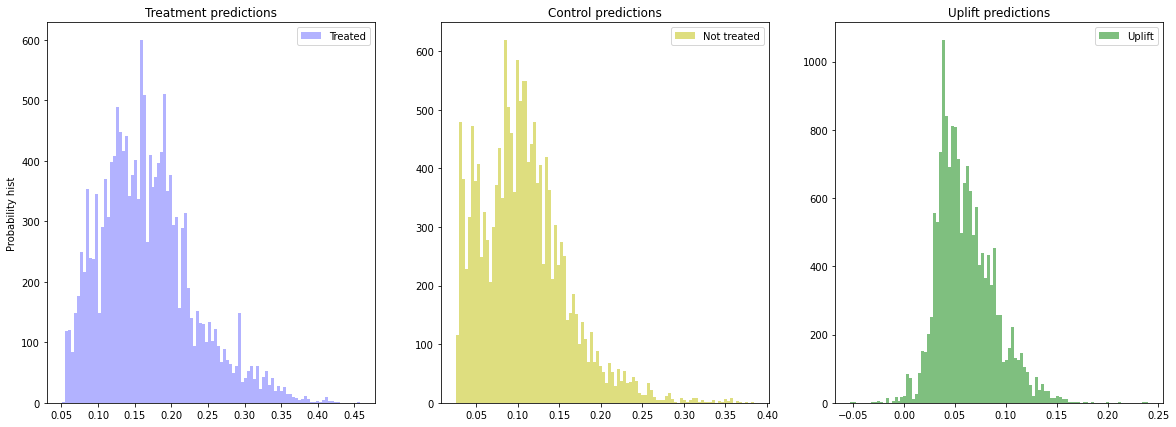

In [52]:
#Одна модель с признаком коммуникации (S-learner)
sm = SoloModel(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=['zip_code','channel'])
)
sm = sm.fit(X_train, y_train, X_treatment_train)
uplift_sm = sm.predict(X_test)

sm_score_1 = uplift_at_k(y_test, uplift_sm, X_treatment_test, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_test, uplift_sm, X_treatment_test, strategy='by_group', k=0.2)

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [53]:
sm_score_1

0.06673351158645277

In [54]:
#Модель с трансформацией классов:
from sklift.models import ClassTransformation


ct = ClassTransformation(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=['zip_code','channel'])
)
ct = ct.fit(X_train, y_train, X_treatment_train)

uplift_ct = ct.predict(X_test)

ct_score_1 = uplift_at_k(y_test, uplift_ct, X_treatment_test, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_test, uplift_ct, X_treatment_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

ct_score_1

0.06470694338341396

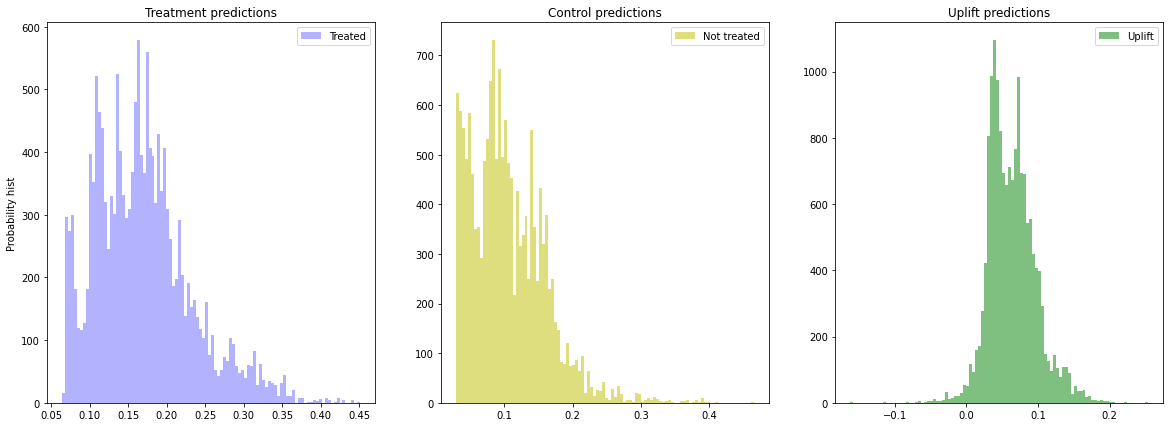

In [55]:
#Две нзависимые модели:
from sklift.models import TwoModels


tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=['zip_code','channel']),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=['zip_code','channel']),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, X_treatment_train
)

uplift_tm = tm.predict(X_test)

tm_score_1 = uplift_at_k(y_test, uplift_ct, X_treatment_test, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_test, uplift_ct, X_treatment_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [56]:
tm_score_1

0.06470694338341396

Задача 4. в конце вывести единую таблицу сравнения метрик uplift@10%, plift@20% 3 моделей

In [58]:
pd.DataFrame(models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.066734,0.058553
1,ClassTransformation,0.064707,0.061093
2,TwoModels,0.064707,0.061093


По метрикам uplift@10% и uplift@20% модели 	ClassTransformation и TwoModels оказываются лучше solo-модели, так как они позволяют выделить сегмент клиентов с большей отдачей от взаимодействия по сравнению с отсутствием взаимодействия: в среднем вероятность отклика клиента после взаимодействия с top 10% клиентов увеличивается на 6,5% по сравнению с отсутствием взаимодействия.